<a href="https://colab.research.google.com/github/fjpcediel87/DeepLearning--Learning/blob/main/03_Working_with_Images_%26_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.80MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.72MB/s]


In [3]:
len(dataset)

60000

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

It's a pair, consisting of a 28x28px image and a label. The image is an object of the class `PIL.Image.Image`, which is a part of the Python imaging library [Pillow](https://pillow.readthedocs.io/en/stable/). We can view the image within Jupyter using [`matplotlib`](https://matplotlib.org/), the de-facto plotting and graphing library for data science in Python.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

The statement `%matplotlib inline` indicates to Jupyter that we want to plot the graphs within the notebook. Without this line, Jupyter will show the image in a popup. Statements starting with `%` are called magic commands and are used to configure the behavior of Jupyter itself. You can find a full list of magic commands here: https://ipython.readthedocs.io/en/stable/interactive/magics.html .

Let's look at a couple of images from the dataset.

Label: 5


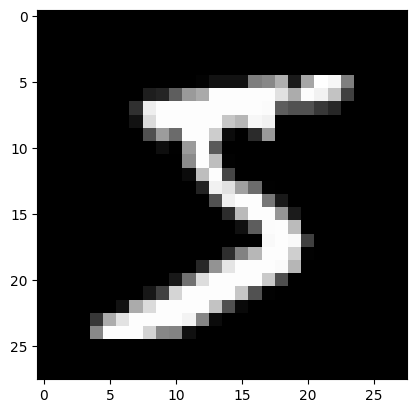

In [7]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


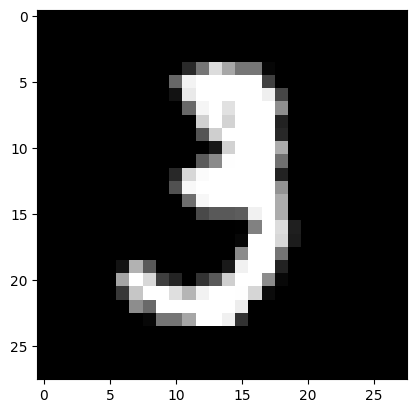

In [8]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 8


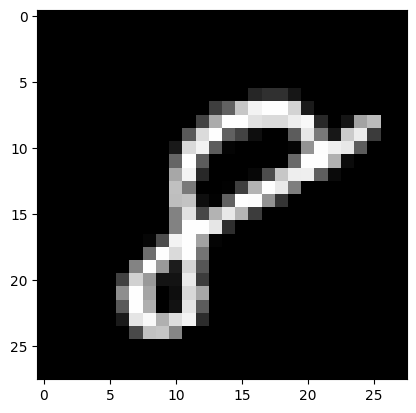

In [9]:
image, label = dataset[59999]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 6


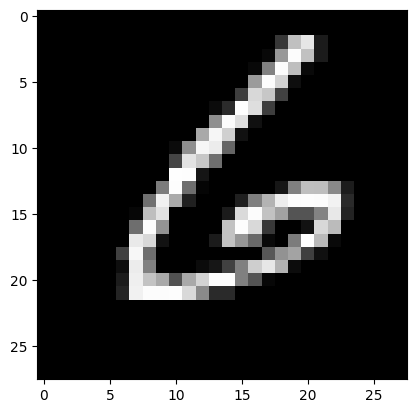

In [12]:
image, label = dataset[60000-2] #Since len(dataset)=6e4, the max element would be 59999.
plt.imshow(image, cmap='gray')
print('Label:', label)

In [8]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The `torchvision.transforms` module contains many such predefined functions. We'll use the `ToTensor` transform to convert images into PyTorch tensors.

In [9]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/',
                train=True,
                transform=transforms.ToTensor())

In [10]:
img_tensor, label = dataset[0] #you can see the number of pixels on the figures above 28 x 28
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [11]:
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


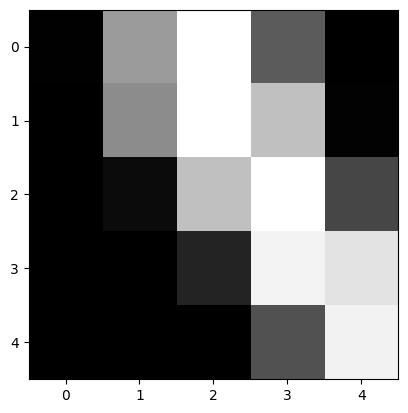

In [12]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

#Training and Validation Datasets





In [13]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [93]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`).

* As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is _flattened_ into a vector of size 784 `(28*28)` before being passed into the model.

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [94]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [16]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0266,  0.0027, -0.0126,  ..., -0.0243, -0.0016, -0.0223],
        [ 0.0136,  0.0109,  0.0163,  ..., -0.0301,  0.0304, -0.0012],
        [-0.0296, -0.0250,  0.0229,  ..., -0.0165, -0.0284, -0.0131],
        ...,
        [-0.0042, -0.0264, -0.0068,  ..., -0.0104, -0.0263,  0.0043],
        [-0.0089, -0.0098,  0.0093,  ...,  0.0068, -0.0129,  0.0331],
        [ 0.0084, -0.0187, -0.0041,  ...,  0.0048,  0.0092,  0.0225]],
       requires_grad=True)

In [17]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0207,  0.0261, -0.0039, -0.0315,  0.0250,  0.0110, -0.0105, -0.0326,
         0.0306,  0.0234], requires_grad=True)

In [18]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    # outputs = model(images)<-- This step caused an error, it was replaced by the two lines below:
    # Reshape the images to a flattened vector
    outputs = model(images.view(images.size(0), -1))
    break

tensor([0, 9, 4, 9, 4, 9, 3, 4, 2, 7, 4, 8, 7, 8, 5, 5, 6, 0, 0, 7, 1, 0, 4, 7,
        5, 8, 9, 0, 5, 8, 2, 9, 0, 9, 5, 1, 3, 5, 2, 1, 2, 8, 8, 6, 9, 4, 4, 9,
        3, 1, 1, 6, 3, 9, 3, 4, 3, 2, 1, 8, 5, 3, 1, 5, 0, 4, 3, 9, 3, 6, 2, 4,
        5, 4, 5, 9, 9, 4, 0, 7, 0, 0, 8, 7, 5, 0, 1, 2, 2, 7, 1, 3, 3, 0, 6, 2,
        0, 3, 7, 2, 5, 8, 5, 5, 0, 1, 8, 8, 9, 7, 6, 4, 3, 2, 1, 0, 6, 0, 2, 8,
        3, 9, 4, 3, 7, 4, 8, 7])
torch.Size([128, 1, 28, 28])


The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data.

In [19]:
images.shape

torch.Size([128, 1, 28, 28])

In [20]:
images.reshape(128, 784).shape

torch.Size([128, 784])

#Note: Creating a class with python

In [39]:
class Person:
    # Class constructor
    def __init__(self, name, age):
        # Object properties
        self.name = name
        self.age = age

    # Method
    def say_hello(self):
        print("Hello my name is " + self.name + "!")

In [40]:
bob = Person("Bob", 32)

In [41]:
bob.name, bob.age

('Bob', 32)

In [42]:
bob.say_hello()

Hello my name is Bob!


You can learn more about Python classes here: https://www.w3schools.com/python/python_classes.asp .



#Let's continue

In [21]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

model = MnistModel()

In [22]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [23]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0120,  0.0145, -0.0243,  ..., -0.0230,  0.0251, -0.0311],
         [ 0.0107,  0.0108,  0.0212,  ..., -0.0258, -0.0214, -0.0033],
         [ 0.0179, -0.0124,  0.0309,  ...,  0.0266, -0.0157, -0.0350],
         ...,
         [ 0.0047,  0.0193,  0.0216,  ..., -0.0073,  0.0103,  0.0040],
         [-0.0347, -0.0225, -0.0356,  ...,  0.0093, -0.0269, -0.0106],
         [ 0.0102, -0.0057,  0.0320,  ..., -0.0248, -0.0196, -0.0287]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0025, -0.0206,  0.0222,  0.0121, -0.0335, -0.0146,  0.0086,  0.0009,
          0.0349, -0.0266], requires_grad=True)]

In [24]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.4229,  0.1846, -0.0987, -0.4609, -0.0032, -0.4371,  0.1222,  0.0670,
         -0.0526,  0.1134],
        [ 0.0545,  0.2039,  0.0434, -0.1890, -0.1330, -0.2632,  0.1668, -0.0479,
         -0.0201,  0.0629]])


In [25]:
import torch.nn.functional as F

We will use the softmax function to convert the outputs to positive and normalise them between 0 and 1.

For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case.

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

![softmax](https://i.imgur.com/EAh9jLN.png)

First, we replace each element `yi` in an output row by `e^yi`, making all the elements positive.

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)



Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

While it's easy to implement the softmax function (you should try it!), we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [26]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0704, 0.1292, 0.0974, 0.0678, 0.1071, 0.0694, 0.1214, 0.1149, 0.1020,
         0.1204],
        [0.1058, 0.1229, 0.1047, 0.0830, 0.0877, 0.0770, 0.1184, 0.0955, 0.0982,
         0.1067]])
Sum:  0.9999998807907104


In [27]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([1, 1, 1, 6, 8, 7, 4, 6, 7, 7, 6, 2, 7, 5, 6, 9, 6, 6, 4, 4, 7, 6, 1, 4,
        9, 8, 1, 7, 7, 3, 8, 6, 9, 6, 1, 1, 5, 6, 0, 4, 6, 7, 8, 6, 8, 6, 7, 4,
        6, 7, 6, 6, 8, 6, 6, 8, 6, 2, 4, 6, 1, 9, 8, 8, 6, 7, 7, 6, 9, 6, 8, 8,
        6, 6, 6, 7, 1, 9, 8, 6, 1, 4, 4, 5, 6, 6, 8, 7, 8, 1, 7, 7, 7, 8, 9, 1,
        1, 8, 6, 6, 6, 7, 7, 9, 6, 6, 1, 5, 0, 1, 4, 4, 6, 9, 8, 6, 6, 4, 1, 4,
        6, 6, 1, 8, 8, 6, 7, 9])
tensor([0.1292, 0.1229, 0.1265, 0.1246, 0.1140, 0.1322, 0.1252, 0.1449, 0.1178,
        0.1263, 0.1545, 0.1089, 0.1242, 0.1175, 0.1335, 0.1273, 0.1321, 0.1194,
        0.1175, 0.1139, 0.1401, 0.1204, 0.1239, 0.1247, 0.1160, 0.1218, 0.1384,
        0.1329, 0.1319, 0.1119, 0.1212, 0.1484, 0.1163, 0.1375, 0.1266, 0.1359,
        0.1241, 0.1329, 0.1179, 0.1296, 0.1220, 0.1220, 0.1267, 0.1315, 0.1382,
        0.1347, 0.1366, 0.1156, 0.1327, 0.1279, 0.1249, 0.1156, 0.1245, 0.1193,
        0.1343, 0.1392, 0.1444, 0.1155, 0.1314, 0.1437, 0.1263, 0.1295, 0.1313,
       

In [28]:
labels

tensor([8, 7, 6, 9, 9, 7, 2, 2, 1, 3, 2, 9, 7, 1, 6, 7, 3, 2, 9, 1, 5, 4, 3, 1,
        9, 1, 8, 5, 8, 7, 9, 4, 6, 5, 8, 7, 6, 3, 4, 5, 6, 1, 5, 5, 2, 1, 0, 7,
        7, 7, 3, 7, 8, 9, 7, 4, 0, 1, 1, 3, 5, 9, 9, 7, 8, 5, 0, 1, 7, 4, 7, 1,
        5, 3, 0, 0, 7, 3, 3, 5, 7, 1, 1, 2, 2, 2, 4, 0, 3, 8, 2, 5, 5, 2, 4, 3,
        3, 1, 3, 1, 5, 7, 2, 0, 4, 6, 7, 2, 4, 1, 1, 1, 1, 6, 9, 0, 0, 1, 6, 7,
        2, 2, 7, 7, 9, 4, 1, 6])

There is no relation between pred and labels because we have not evaluated the loss function.


# Evaluation Metric and Loss Function

In [33]:
outputs


tensor([[-0.4229,  0.1846, -0.0987,  ...,  0.0670, -0.0526,  0.1134],
        [ 0.0545,  0.2039,  0.0434,  ..., -0.0479, -0.0201,  0.0629],
        [-0.0620,  0.1770, -0.1221,  ...,  0.0325, -0.0933,  0.0411],
        ...,
        [-0.0101,  0.2206, -0.2856,  ..., -0.2037, -0.0486,  0.1314],
        [-0.3003, -0.1639,  0.0207,  ...,  0.1023,  0.0015, -0.1516],
        [-0.0006, -0.0117,  0.0011,  ..., -0.2589, -0.1298,  0.0221]],
       grad_fn=<AddmmBackward0>)

In [35]:
preds = torch.max(outputs, dim=1)
preds

torch.return_types.max(
values=tensor([0.1846, 0.2039, 0.1770, 0.2091, 0.0718, 0.3095, 0.1876, 0.4590, 0.0566,
        0.1672, 0.4904, 0.0201, 0.1647, 0.1262, 0.1913, 0.2281, 0.2535, 0.1950,
        0.0725, 0.0463, 0.3064, 0.1145, 0.2060, 0.2125, 0.0619, 0.1597, 0.3222,
        0.2281, 0.2486, 0.0658, 0.1932, 0.4546, 0.0587, 0.2995, 0.2292, 0.2777,
        0.1371, 0.2379, 0.0988, 0.1866, 0.2066, 0.1287, 0.2109, 0.1453, 0.2528,
        0.1913, 0.3013, 0.1501, 0.2743, 0.2051, 0.2275, 0.0879, 0.1237, 0.0791,
        0.1834, 0.3475, 0.3725, 0.1040, 0.2236, 0.3431, 0.1877, 0.1593, 0.2137,
        0.0483, 0.4114, 0.1353, 0.3306, 0.1299, 0.2041, 0.2940, 0.2031, 0.1957,
        0.2243, 0.1607, 0.2621, 0.3081, 0.2134, 0.1400, 0.2253, 0.3774, 0.4161,
        0.2111, 0.2040, 0.3055, 0.1533, 0.3245, 0.0423, 0.1724, 0.2206, 0.1894,
        0.2291, 0.4639, 0.4131, 0.0613, 0.2781, 0.2535, 0.2896, 0.2482, 0.2207,
        0.2213, 0.3051, 0.4092, 0.1800, 0.2948, 0.1447, 0.2431, 0.3185, 0.3055,
        0

In [45]:
torch.sum(preds.indices==labels)

tensor(11)

In [47]:
torch.sum(preds.indices==labels).item()

11

In [49]:
len(preds.indices)

128

In [54]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [56]:
_, preds = torch.max(outputs, dim=1)

In [57]:
preds

tensor([1, 1, 1, 6, 8, 7, 4, 6, 7, 7, 6, 2, 7, 5, 6, 9, 6, 6, 4, 4, 7, 6, 1, 4,
        9, 8, 1, 7, 7, 3, 8, 6, 9, 6, 1, 1, 5, 6, 0, 4, 6, 7, 8, 6, 8, 6, 7, 4,
        6, 7, 6, 6, 8, 6, 6, 8, 6, 2, 4, 6, 1, 9, 8, 8, 6, 7, 7, 6, 9, 6, 8, 8,
        6, 6, 6, 7, 1, 9, 8, 6, 1, 4, 4, 5, 6, 6, 8, 7, 8, 1, 7, 7, 7, 8, 9, 1,
        1, 8, 6, 6, 6, 7, 7, 9, 6, 6, 1, 5, 0, 1, 4, 4, 6, 9, 8, 6, 6, 4, 1, 4,
        6, 6, 1, 8, 8, 6, 7, 9])

accuracy2 is another version of accuracy, please note in accuracy, preds is the second matrix, but in accuracy2 preds contains both matrixes 'tensor' and 'indices'.



In [58]:
def accuracy2(outputs, labels):
    preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds.indices == labels).item() / len(preds.indices))

In [55]:
accuracy(outputs, labels)

tensor(0.0859)

In [59]:
accuracy2(outputs, labels)

tensor(0.0859)

Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

For these reasons, accuracy is often used as an **evaluation metric** for classification, but not as a loss function. A commonly used loss function for classification problems is the **cross-entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [60]:
loss_fn = F.cross_entropy

In [61]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3171, grad_fn=<NllLossBackward0>)


## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem.

We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.


In [62]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results

    for epoch in range(epochs):

        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

#list comprehension in Python

In [70]:
l1=[1,2,3,4]

In [76]:
l2 =[x*2 for x in l1]
l2

[2, 4, 6, 8]

#Let's continue with the *evaluate* function

In [77]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [78]:
outputs = [model.validation_step(batch) for batch in val_loader]

AttributeError: 'MnistModel' object has no attribute 'validation_step'

We need to define that function: validation_step, and others.

In [96]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [80]:
outputs = [model.validation_step(batch) for batch in val_loader]

In [81]:
model.validation_epoch_end(outputs)

{'val_loss': 2.335648536682129, 'val_acc': 0.09216772019863129}

The values above are the mean of the batch losses and accuracies calculated by validation_epoc_end function

In [97]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.302424669265747, 'val_acc': 0.10799050331115723}

In [98]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9324, val_acc: 0.6258
Epoch [1], val_loss: 1.6659, val_acc: 0.7216
Epoch [2], val_loss: 1.4675, val_acc: 0.7631
Epoch [3], val_loss: 1.3176, val_acc: 0.7851
Epoch [4], val_loss: 1.2023, val_acc: 0.7996


In [99]:
history2 = fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7482, val_acc: 0.8426
Epoch [1], val_loss: 0.6166, val_acc: 0.8591
Epoch [2], val_loss: 0.5519, val_acc: 0.8654
Epoch [3], val_loss: 0.5118, val_acc: 0.8705
Epoch [4], val_loss: 0.4847, val_acc: 0.8751


In [100]:
history3 = fit(5, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4178, val_acc: 0.8884
Epoch [1], val_loss: 0.3884, val_acc: 0.8922
Epoch [2], val_loss: 0.3708, val_acc: 0.8961
Epoch [3], val_loss: 0.3597, val_acc: 0.8988
Epoch [4], val_loss: 0.3499, val_acc: 0.9003


In [101]:
history4 = fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3405, val_acc: 0.9037
Epoch [1], val_loss: 0.3298, val_acc: 0.9072
Epoch [2], val_loss: 0.3245, val_acc: 0.9087
Epoch [3], val_loss: 0.3199, val_acc: 0.9079
Epoch [4], val_loss: 0.3164, val_acc: 0.9092


In [102]:
history5 = fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3148, val_acc: 0.9119
Epoch [1], val_loss: 0.3063, val_acc: 0.9150
Epoch [2], val_loss: 0.3188, val_acc: 0.9077
Epoch [3], val_loss: 0.3008, val_acc: 0.9160
Epoch [4], val_loss: 0.3097, val_acc: 0.9096


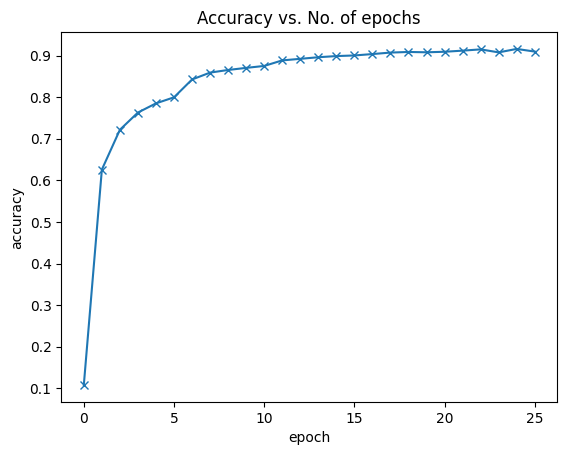

In [103]:
history = [result0] + history1 + history2 + history3 + history4 + history5
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [104]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


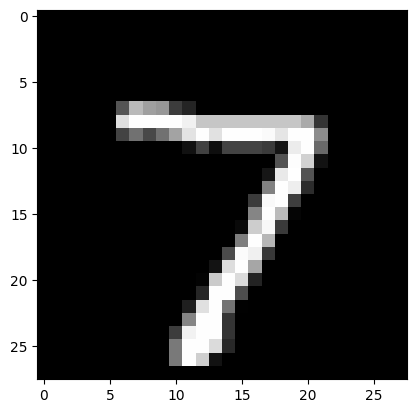

In [105]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [106]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Let's try it out with a few images.

Label: 7 , Predicted: 7


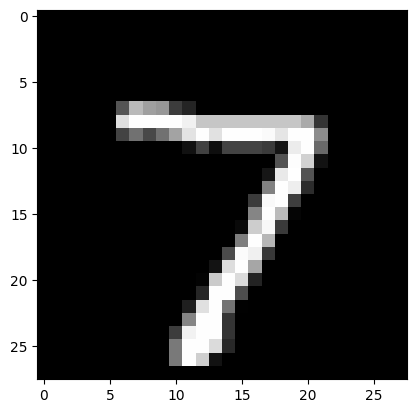

In [107]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


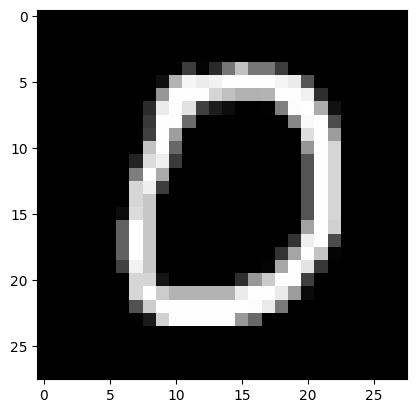

In [108]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


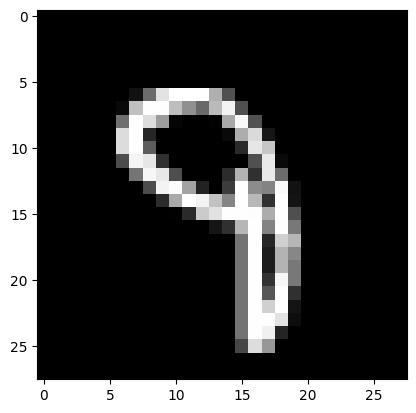

In [109]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


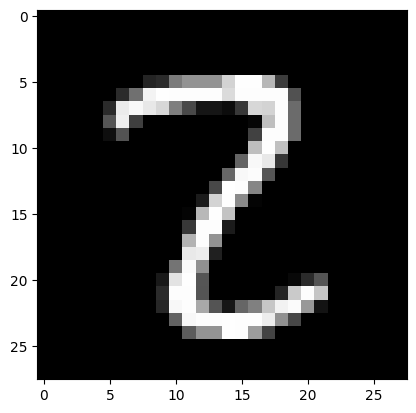

In [110]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

I got a better result because I reached accuracy near 0.915 compared to the guide in which an accuracy of 0.85 was reached.

In [111]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.27995893359184265, 'val_acc': 0.922070324420929}

## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [112]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model.

In [113]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-2.1304e-02,  3.4415e-02,  1.7950e-02,  ...,  6.2304e-05,
                       -8.3050e-03, -1.7202e-02],
                      [ 8.2354e-03, -2.6919e-02,  3.5248e-02,  ..., -1.3891e-02,
                        1.4713e-02, -2.2473e-02],
                      [-3.4586e-02, -1.0968e-02, -1.7384e-02,  ..., -2.9376e-02,
                        3.6188e-03,  2.5677e-02],
                      ...,
                      [-2.5262e-02, -6.0856e-03, -9.8838e-03,  ..., -4.3956e-03,
                       -5.5066e-03, -9.5026e-03],
                      [-8.1941e-03, -2.0439e-02, -1.8700e-02,  ..., -2.8437e-02,
                       -2.0779e-02, -6.2488e-03],
                      [-2.8291e-03, -1.1752e-02,  3.2628e-02,  ...,  1.0549e-02,
                        1.3749e-02, -3.1831e-02]])),
             ('linear.bias',
              tensor([-0.5516,  0.4609,  0.1731, -0.3303, -0.0365,  1.8307, -0.2066,  0.9354,
                      -1.8980,

To load the model weights, we can instante a new object of the class `MnistModel`, and use the `.load_state_dict` method.

In [114]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-2.1304e-02,  3.4415e-02,  1.7950e-02,  ...,  6.2304e-05,
                       -8.3050e-03, -1.7202e-02],
                      [ 8.2354e-03, -2.6919e-02,  3.5248e-02,  ..., -1.3891e-02,
                        1.4713e-02, -2.2473e-02],
                      [-3.4586e-02, -1.0968e-02, -1.7384e-02,  ..., -2.9376e-02,
                        3.6188e-03,  2.5677e-02],
                      ...,
                      [-2.5262e-02, -6.0856e-03, -9.8838e-03,  ..., -4.3956e-03,
                       -5.5066e-03, -9.5026e-03],
                      [-8.1941e-03, -2.0439e-02, -1.8700e-02,  ..., -2.8437e-02,
                       -2.0779e-02, -6.2488e-03],
                      [-2.8291e-03, -1.1752e-02,  3.2628e-02,  ...,  1.0549e-02,
                        1.3749e-02, -3.1831e-02]])),
             ('linear.bias',
              tensor([-0.5516,  0.4609,  0.1731, -0.3303, -0.0365,  1.8307, -0.2066,  0.9354,
                      -1.8980,

In [115]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.27995893359184265, 'val_acc': 0.922070324420929}